In [1]:
import numpy as np
import healpy as hp
import pymaster as nmt
from scipy import optimize
from scipy.linalg import det
import matplotlib.pyplot as plt


In [2]:
nside=256
freqs=np.arange(544,1088,step=1)
# nfreqs=len(freqs)
nfreqs=181
lmax=2*nside #3*nside -1
almsize=hp.Alm.getsize(lmax)
r=3 #foreground model rank
r_total=3
n_bins=51

In [3]:
b= nmt.NmtBin.from_lmax_linear(lmax, nlb=10)
n_bins = b.get_n_bands()
leff = b.get_effective_ells()
leff.shape

(51,)

In [4]:
fgds_binned=np.load('/home/iloveorcas/MASS_Thesis/HI/fgds_binned.npy')
noise_binned=np.load('/home/iloveorcas/MASS_Thesis/HI/noise_binned.npy')
c_hat=np.load('/home/iloveorcas/MASS_Thesis/HI/binned_empirical.npy')

In [5]:
def is_psd(P, tol=1e-15):
    eigenvalues = np.linalg.eigvalsh(P)  # symmetric-optimized
    return np.all(eigenvalues >= -tol) 
print("Is model PSD?", is_psd(c_hat))

Is model PSD? True


In [6]:
fgds_binned.shape

(51, 181, 181)

In [7]:
def pca(empirical, r):
    """
    Perform PCA on the covariance matrix.
    
    Parameters:
    ----------
    c_hat : np.ndarray
        Covariance matrix of shape (n_bins, n_freq, n_freq).
    
    r : int
        Number of principal components to retain.
    
    Returns:
    -------
    F : np.ndarray
        Matrix of shape (n_freq, r) containing the principal components.
    
    P_b : np.ndarray
        Matrix of shape (n_bins, r, r) containing the eigenvalues and eigenvectors.
    """
    # Perform PCA
    R_global = np.mean(empirical, axis=0)  # c_hat has shape (n_bins, n_freqs, n_freqs)
    #eigen decompositiom
    eigvals, eigvecs = np.linalg.eigh(R_global) #ascending order
    #Take the top r eigenvectors:
    F_i = eigvecs[:, -r:]  # largest eigenvectors
    epsilon=1e-6

    P_b = np.zeros((n_bins, r, r))
    for b in range(n_bins):
        P_b[b] =np.dot( F_i.T , np.dot(empirical[b] , F_i)) #projecting the empirical covariance into the subspace spanned by F.
        P_b[b] = 0.5 * (P_b[b] + P_b[b].T) + epsilon * np.eye(r)
    return eigvals,F_i, P_b*231


In [8]:
def pca_extended_random_fill(empirical, r_total, r_extra):
    """
    PCA initialization where P_b is projected only on the top-r components, and the rest is filled with small random values.

    Parameters
    ----------
    empirical : np.ndarray
        Empirical covariance of shape (n_bins, n_freqs, n_freqs)
    r : int
        Number of principal components to use for projection
    r_extra : int
        Number of extra components to pad (not projected)
    epsilon : float
        Small diagonal regularization
    scale : float
        Scaling of the projected P_b
    random_seed : int
        For reproducibility

    Returns
    -------
    eigvals : np.ndarray
        Eigenvalues of global empirical covariance
    F_i : np.ndarray
        (n_freqs, r + r_extra) eigenvector basis
    P_b : np.ndarray
        (n_bins, r + r_extra, r + r_extra) initial covariance in new basis
    """
    epsilon=1e-6
    scale=100
    random_seed=42
    np.random.seed(random_seed)
    n_bins, n_freqs, _ = empirical.shape
    R_global = np.mean(empirical, axis=0)

    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(R_global)
    r =r_total-r_extra

    # Take top r + r_extra eigenvectors
    F_i = eigvecs[:, -r_total:]  # (n_freqs, r_total)

    # Initialize P_b
    P_b = np.zeros((n_bins, r_total, r_total))
    P_psd=np.zeros((n_bins, r_total, r_total))

    for b in range(n_bins):
        # Project empirical onto first r components
        Pb_projected = np.dot(F_i[:, :r].T, np.dot( empirical[b] ,F_i[:, :r]))
        Pb_projected = 0.5 * (Pb_projected + Pb_projected.T)  #symmetry

        #projected part
        P_b[b, :r, :r] = Pb_projected * scale

        # Fill remaining block (r:r_total, r:r_total) with small random positive values
        rand_block = np.random.rand(r_extra, r_extra)* epsilon
        
        rand_block = 0.5 * (rand_block + rand_block.T) # symmetrize
        P_b[b, r:, r:] = rand_block
        
        w, V = np.linalg.eigh(P_b[b])
        w_clipped = np.clip(w, 0, None)   # set negatives to zero
        P_psd[b] = V @ np.diag(w_clipped) @ V.T

        # Optionally: set off-diagonal coupling blocks to zero (decoupled initialization)
        # P_b[b, :r, r:] = 0
        # P_b[b, r:, :r] = 0

    return eigvals, F_i, P_psd


In [9]:
def guess_params(nfreqs,n_bins, r):
    
    #Initial guess for F
    # F_i= np.zeros((nfreqs, r))# N_channels x r
    F_i= np.random.randn(nfreqs, r)

    # initial guess for P_l for each bin
    P_l=np.zeros((n_bins, r,r))
    for bin in range(n_bins):
        A = np.random.randn(r, r)
        # P_l[bin,:,:]= np.identity(r) #r x r #symmetric
        P_l[bin,:,:]=np.dot(A , A.T) + 1e-2 * np.eye(r) #strictly positive definite + symmetric
    return F_i, P_l


In [ ]:
_,F_pca, P_b_pca = pca(c_hat,r)
# F_pca, P_b_pca=guess_params(nfreqs, n_bins,r)
# e,F_pca, P_b_pca = pca_extended_random_fill(c_hat,5,2)
print(F_pca.shape)
print(P_b_pca.shape)
params_pca = np.concatenate([F_pca.flatten(), P_b_pca.flatten()])
# print(params_pca.shape)

# # Check recovery
# F_re = params_pca[:nfreqs * r].reshape((nfreqs, r))
# P_b_re = params_pca[nfreqs * r:].reshape((n_bins, r, r))
# print(F_re.shape)
# print(P_b_re.shape)
# print(F_re.size)
# print(P_b_re.size)

# np.allclose(F_pca, F_re)  # should return True
# np.allclose(P_b_pca, P_b_re)  # should return True


(181, 3)
(51, 3, 3)


In [9]:
def model_covariance(F, P_b, C_noise, n_bins):
    
    # F: (N_channels, r), P_b: (r, r), C_HI & C_noise: (N_channels, N_channels)
    C_b= np.zeros((n_bins, nfreqs, nfreqs))
    for b in range(n_bins):
        C_b[b,:,:]= C_noise[b,:,:] + np.dot(F,np.dot(P_b[b,:,:], F.T))
    return C_b

In [10]:
c_model= model_covariance(F_pca, P_b_pca,noise_binned, n_bins)

In [55]:
fgds_binned[:,0,0]/ noise_binned[:,0,0]

array([8.73653714e+00, 2.15532438e+00, 1.07884916e+00, 7.56783442e-01,
       4.80775529e-01, 3.47542035e-01, 2.53263454e-01, 2.16582096e-01,
       1.61889521e-01, 1.47693329e-01, 1.08872451e-01, 9.67544680e-02,
       7.36156591e-02, 6.15138780e-02, 5.46779533e-02, 4.64959970e-02,
       4.05263975e-02, 3.34477858e-02, 2.83554736e-02, 2.47494595e-02,
       1.89494293e-02, 1.64118633e-02, 1.31346601e-02, 1.17417566e-02,
       1.08748316e-02, 8.87329945e-03, 7.39742453e-03, 6.58290043e-03,
       5.48934050e-03, 5.31864216e-03, 4.59317701e-03, 4.55826438e-03,
       4.07554698e-03, 3.69868681e-03, 3.06697672e-03, 3.03764932e-03,
       2.63911130e-03, 2.51382695e-03, 2.26503855e-03, 2.09025700e-03,
       2.00118326e-03, 1.94588029e-03, 1.69091005e-03, 1.50160689e-03,
       1.46460064e-03, 1.34989944e-03, 1.18576430e-03, 1.12484919e-03,
       1.01011425e-03, 9.78540910e-04, 8.94023048e-04])

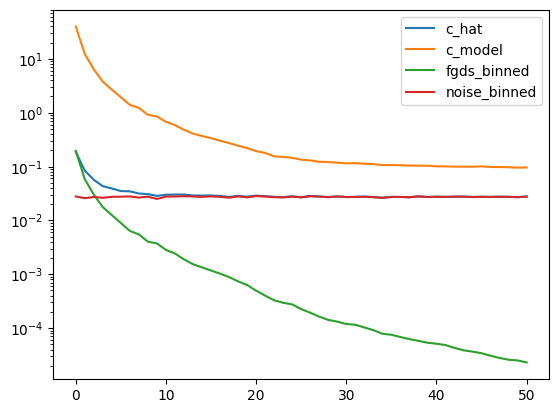

In [13]:
plt.plot(c_hat[:,10,10], label='c_hat')
plt.plot(c_model[:,10,10], label='c_model')
plt.plot(fgds_binned[:,10,10], label='fgds_binned')
plt.plot(noise_binned[:,10,10], label='noise_binned')

plt.yscale('log')
plt.legend()

In [14]:
def is_psd(P, tol=0):
    eigenvalues = np.linalg.eigvalsh(P)  # symmetric-optimized
    return np.all(eigenvalues >= -tol)  
print("Is model PSD?", is_psd(c_model))

Is model PSD? True


In [15]:
def smica(params, noise,empirical,  n_bins, nfreqs, r):
    
    # Reshape the flattened params back into F_init and P_b_init
    
    F_i = params[:nfreqs * r].reshape((nfreqs, r))
    P_b = params[nfreqs * r:].reshape((n_bins,r,r))
    
    
    """# === Normalize columns of F and rescale P accordingly ===
    for i in range(r):
        norm = np.linalg.norm(F[:, i])

        F[:, i] /= norm  # normalize column
        for b in range(n_bins):
            P_b[b, i, :] *= norm
            P_b[b, :, i] *= norm  # symmetric scaling"""
    
    
    # norm = np.linalg.norm(F, axis=0)
    
    # # Normalize F
    # F_normalized = F / norm        
    # # Adjust P_b: D^{-1} P_b D^{-1}
    # D_inv = np.diag(1.0 / norm)
    # for b in range(n_bins):
    #     P_b[b] = D_inv @ P_b[b] @ D_inv
                
    # === Compute the cost function ===            
    cost=0
    # model=np.zeros((n_bins, nfreqs, nfreqs))
    # model_inv=np.zeros((n_bins, nfreqs, nfreqs))
    
    # term=np.zeros(n_bins)
    for b in range(n_bins):
        model=  noise[b] + np.dot(F_i, np.dot(P_b[b], F_i.T))
        model_inv= np.linalg.inv(model)
        
        sign, logdet= np.linalg.slogdet(np.dot(empirical[b],model_inv))
        trace=np.trace(np.dot(empirical[b] , model_inv))
        
        term = -logdet + trace-nfreqs
        cost += term
        
    return cost

In [16]:
smica(params_pca, noise_binned, c_hat, n_bins, nfreqs, r_total)

np.float64(2386.919033999015)

In [17]:
def norm_constraints(params, nfreqs, r, n_bins):
    F_i= params[:nfreqs * r].reshape((nfreqs, r))
    norm=np.zeros(r)
    for j in range(r):
        norm[j]=np.linalg.norm(F_i[:,j])
    return norm

In [18]:
from scipy.optimize import NonlinearConstraint

constraint = NonlinearConstraint(
    lambda params_pca: norm_constraints(params_pca, nfreqs, r_total, n_bins),
    lb=np.ones(r_total),  # lower bounds = 1
    ub=np.ones(r_total)   # upper bounds = 1 → equality constraint
)

In [19]:
np.linalg.norm(F_pca[:, 1])

np.float64(1.0)

In [17]:
def jacobian_2(params, noise,  empirical, n_bins, nfreqs, r):
    
    delta_ell=10
    # Reshape the flattened params back into F_init and P_b_init
    F = params[:nfreqs * r].reshape((nfreqs, r))
    P_b = params[nfreqs * r:].reshape((n_bins,r,r))
    
    """# === Normalize columns of F and rescale P accordingly ===
    for i in range(r):
        norm = np.linalg.norm(F[:, i])
        
        F[:, i] /= norm  # normalize column
        for b in range(n_bins):
            # Scale row i and column i of P_b[b] accordingly
            P_b[b, i, :] *= norm
            P_b[b, :, i] *= norm """
            
    # Compute norms of each column of F
    # norm = np.linalg.norm(F, axis=0)
    
    # # Normalize F
    # F_normalized = F / norm        
    # # Adjust P_b: D^{-1} P_b D^{-1}
    # D_inv = np.diag(1.0 / norm)
    # for b in range(n_bins):
    #     P_b[b] = D_inv @ P_b[b] @ D_inv
    
    grad_P=np.zeros_like(P_b) # Derivative wrt P_b
    grad_F=np.zeros_like(F) # Derivative wrt F
    
    for b in range(n_bins):
        
        R= noise[b]+np.dot(F, np.dot(P_b[b], F.T)) # model covariance depending on only unknown parameters
        """try:
            R_inv = np.linalg.inv(R)
        except np.linalg.LinAlgError:
            # Optional: add small regularization to make model invertible
            R += 1e-6 * np.identity(nfreqs)
            R_inv = np.linalg.inv(R)"""
        R_inv= np.linalg.inv(R)
        
        Delta= R_inv - np.dot(R_inv,np.dot(empirical[b], R_inv)) #nf x nf

        # ∂φ/∂P_q 
        grad_P[b,:,:]= np.dot(F.T, np.dot(Delta, F)) # (r,r)
        # ∂φ/∂F
        grad_F += 2*np.dot(Delta, np.dot(F, P_b[b])) # (nf,r)
        
    # Flatten the gradients
    grad_P_flat = grad_P.flatten()
    grad_F_flat = grad_F.flatten()
    # print(grad_F_flat.shape)
    # print(grad_P_flat.shape)
    grad_total= np.concatenate([grad_F_flat.flatten(), grad_P_flat.flatten()])
    return grad_total

In [18]:
jacobian_2(params_pca, noise_binned, c_hat, n_bins, nfreqs, r_total)

array([ 2.42206982e+00, -1.69314128e+00,  9.68284470e+00, ...,
       -2.92338212e-04, -2.32420365e-03,  1.42075500e-01], shape=(1002,))

In [22]:
def fin_diff_fun(params_pca, noise_binned, c_hat, n_bins, nfreqs, r):
    fin_diff= np.load('approx_grad_2.npy')
    return fin_diff
    

In [161]:
def auto_grad_fun(params_pca, noise_binned, c_hat, n_bins, nfreqs, r):
    auto_grad= np.load('autograd1.npy')
    return auto_grad

In [112]:
import autograd.numpy as np
from autograd import grad

auto_grad=grad(smica)

In [19]:
res = optimize.minimize(
    smica,
    x0=params_pca,
    args=( noise_binned,c_hat, n_bins, nfreqs,r_total),
    method='trust-constr',
    
    jac=jacobian_2,
    # options={'ftol' : 1e-11, 'gtol': 1e-11, 'maxcor':20,'maxls': 1000}
    options={'disp': True, 'maxiter':100, 'gtol':1e-1, 'xtol':1e-10,'barrier_tol': 1e-6, 'verbose': 2}
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +2.3869e+03 | 1.00e+00 | 2.35e+01 | 0.00e+00 |
|   2   |   2   |   1   | +2.1445e+03 | 7.00e+00 | 3.25e+02 | 0.00e+00 |
|   3   |   3   |   2   | +2.1445e+03 | 7.00e-01 | 3.25e+02 | 0.00e+00 |
|   4   |   4   |   4   | +2.0844e+03 | 1.80e+00 | 2.05e+02 | 0.00e+00 |
|   5   |   5   |   7   | +2.0844e+03 | 1.96e-01 | 2.05e+02 | 0.00e+00 |
|   6   |   6   |   9   | +1.9825e+03 | 1.37e+00 | 1.80e+02 | 0.00e+00 |
|   7   |   7   |  14   | +1.9825e+03 | 3.04e-01 | 1.80e+02 | 0.00e+00 |
|   8   |   8   |  17   | +1.9042e+03 | 6.08e-01 | 1.57e+02 | 0.00e+00 |
|   9   |   9   |  23   | +1.9042e+03 | 1.21e-01 | 1.57e+02 | 0.00e+00 |
|  10   |  10   |  25   | +1.9012e+03 | 1.21e-01 | 2.04e+02 | 0.00e+00 |
|  11   |  11   |  27   | +1.8811e+03 | 2.41e-01 | 1.31e+02 | 0.00e+00 |
|  12   |  12   |  34   | +1.8811e+03 | 4.92e-02 | 

In [20]:
from pprint import pprint
pprint(res)

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: 1725.5930702006494
                x: [-2.419e-03 -1.685e-03 ...  1.055e-01  6.981e+00]
              nit: 81
             nfev: 81
             njev: 81
             nhev: 0
         cg_niter: 187
     cg_stop_cond: 2
             grad: [-7.525e+00 -5.199e+00 ... -8.624e-03  2.980e-02]
  lagrangian_grad: [-7.525e+00 -5.199e+00 ... -8.624e-03  2.980e-02]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 1117.1683700846502
 constr_violation: 0
   execution_time: 32.40796756744385
        tr_radius: 1.2925264033532193e-11
   constr_penalty: 1.0
            niter: 81


In [33]:
result=res.x
print(result.shape)
P_b_out = result[nfreqs*r_total:].reshape((n_bins,r_total, r_total))
F_out = result[:nfreqs*r_total].reshape((nfreqs, r_total))
print(P_b_out.shape)
print(F_out.shape)
C_result=np.zeros_like(c_hat)
for b in range(n_bins):
    
    C_result[b]=np.dot(F_out, np.dot(P_b_out[b], F_out.T))


(1002,)
(51, 3, 3)
(181, 3)


In [22]:
np.all(np.linalg.eigvals(C_result) >=0)

np.True_

In [23]:
np.all(np.linalg.eigvals(P_b_pca) >=0)

np.True_

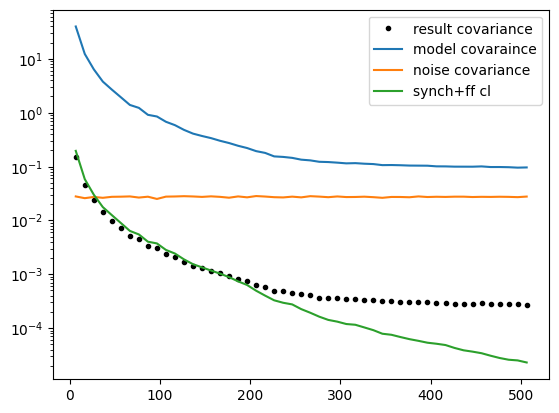

In [67]:
plt.plot(leff,C_result[:,10,10],'k.', label="result covariance")
# plt.plot(leff,c_hat[:,10,10], label="empirical covariance")
plt.plot(leff,c_model[:,10,10], label="model covaraince")

plt.plot(leff,noise_binned[:,10,10], label="noise covariance")
plt.plot(leff, fgds_binned[:,10,10], label="synch+ff cl")
plt.yscale('log')
plt.legend()

In [45]:
snr=np.mean(fgds_binned[0]/noise_binned[0])
print(snr)

inf


/tmp/ipykernel_595/1594427546.py:1: RuntimeWarning: divide by zero encountered in divide
  snr=np.mean(fgds_binned[0]/noise_binned[0])


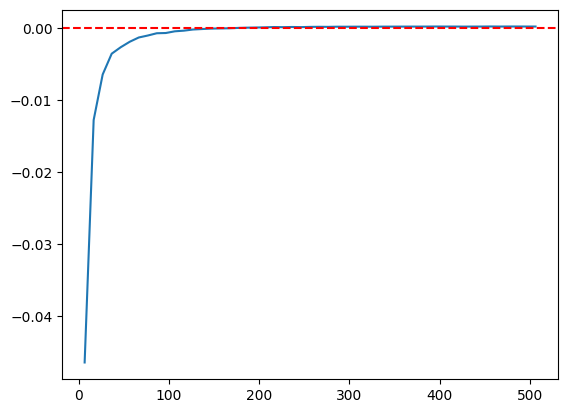

In [72]:
# plt.plot(leff,(C_result[:,10,10] - c_hat[:,10,10]))
plt.plot(leff,( C_result[:,10,10]- fgds_binned[:,10,10]))
# plt.ylim(-0.05,0.05)
plt.axhline(0, color='r', linestyle='--')
# plt.title('Difference between result and empirical covariance')
plt.show()

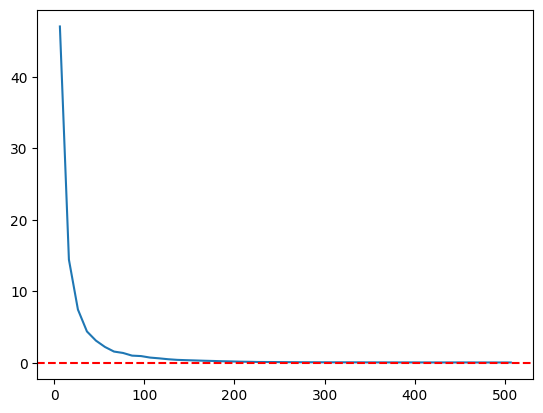

In [26]:
plt.plot(leff,(-c_hat[:,0,0] +c_model[:,0,0]))
# plt.ylim(-0.05,0.05)
plt.axhline(0, color='r', linestyle='--')